In [2]:
#Scripts for African Mz and Sg Suitability Paper
#The whole process has five steps or functions
#Step 1: identify peaks of the yield series of mean yield for season 1 and season 2, calculate if 
         #there is a changing trends and where
#Step 2: identify the sowing period for season 1 and season 2, calculate the onset and concession,
         #If there is a change and where
#Step 3: Pick the maximum yield (namely peak yield) and correlate the yield with corresponding climate Indeices
#Step 4: Compute smoothes yield and CV for every 10 years, here we need to return a combined table
         #Return table ma_matu1.txt -- colnames: simunit.sea.yld1...cv1...peak.peak-ch.onset.onset-ch.period.period-ch.
#Step 5: Compute SI based on summrized information that you want to include
         #mz.txt -- colnames: 

In [924]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import seaborn as sns
import geopandas as gpd
import rasterio

In [58]:
#import statsmodels.api as sm
import itertools
from statistics import mode

# PLOT 1 - YIELD CHANGES AND SI OF CULTIVAR GROUPS OVER TIME

In [ ]:
"""
Plot 1 - Changes of simulated maize yield over years across three cultivar maturity groups
         a. With reported sowing windows?
         b. With optimum and fixed sowing window?
         c. With optimum and decaldly varying sowing window?
         d. With optimum yearly sowing window
"""
#Step 1. Combining all years and estimate the changing trends, For regional changing trends
#Step 2. Understand which environment factors have driven this change
#Step 3. Estimate smoothed My/CV to explore if there are temporal transitional changing points

In [727]:
#Estimate yield change over time, yield is aggreated into the continent
sowing_window=['ReportedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
result=pd.DataFrame(columns=['sowingwindow','type','cul','sea']+[x for x in range(1971,2022)])
area=pd.DataFrame(columns=['sowingwindow','cul','sea','area'])
for sw in sowing_window:
    yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
    for cul in [1,2,3]:
        for se in [1,2]:
            temp=yld[(yld['matu']==cul)&(yld['sea']==se)].fillna(0)
            #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
            temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
            temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
            #0.75 quantile
            result.loc[len(result),]=[sw,'Q75%',cul,se]+temp.iloc[:,3:].quantile(0.75).tolist()
            #0.25 quantile
            result.loc[len(result),]=[sw,'Q25%',cul,se]+temp.iloc[:,3:].quantile(0.25).tolist()
            #area-weighted area
            temp=temp.merge(df,how='left').fillna(0)
            result.loc[len(result),]=[sw,'mean',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)/sum(temp["A"]),3) for x in range(1971,2022)]
            area.loc[len(area)]=[sw,cul,se,sum(temp["A"])]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_allgrids_WeightedYld_Over80%G1se2.csv", index=False)

,sowingwindow,cul,sea,area
0,ReportedSow,1,1,1.741482e+07
1,ReportedSow,1,2,7.996422e+06
2,ReportedSow,2,1,1.943427e+07
3,ReportedSow,2,2,8.970912e+06
4,ReportedSow,3,1,2.239181e+07
5,ReportedSow,3,2,9.860517e+06
6,OptimumFixedSow,1,1,2.624930e+07
7,OptimumFixedSow,1,2,1.027670e+07
8,OptimumFixedSow,2,1,2.673476e+07
9,OptimumFixedSow,2,2,1.038932e+07


In [730]:
sowing_window=['ReportedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
result=pd.DataFrame(columns=['sowingwindow','type','cul','sea']+[x for x in range(1971,2022)])
area=pd.DataFrame(columns=['sowingwindow','cul','sea','area'])
for sw in sowing_window:
    yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
    for cul in [1,2,3]:
        for se in [1,2]:
            temp=yld[(yld['matu']==cul)&(yld['sea']==se)].fillna(0)
            #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
            temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
            temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
            #0.75 quantile
            result.loc[len(result),]=[sw,'Q75%',cul,se]+temp.iloc[:,3:].quantile(0.75).tolist()
            #0.25 quantile
            result.loc[len(result),]=[sw,'Q25%',cul,se]+temp.iloc[:,3:].quantile(0.25).tolist()
            #area-weighted area
            temp=temp.merge(df)
            temp.fillna(0,inplace=True)
            result.loc[len(result),]=[sw,'mean',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T),3) for x in range(1971,2022)]
            area.loc[len(area)]=[sw,cul,se,sum(temp["A"])]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_allgrids_Production_Over80%G1se2.csv", index=False)

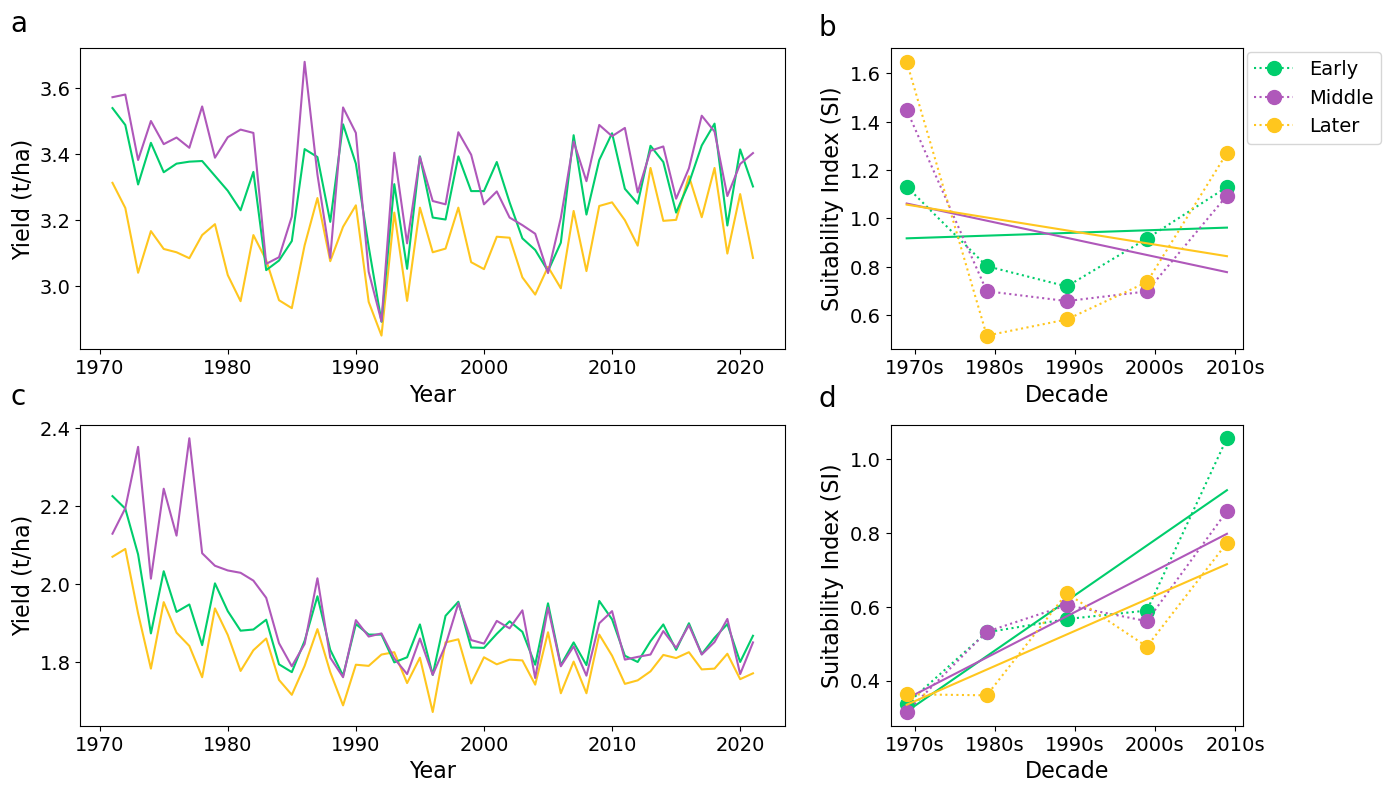

In [774]:
#Plotting
#type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_allgrids_WeightedYld_Over80%G1se2.csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
width_ratios = [2, 1]
label=['Early','Middle','Later']
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': width_ratios},figsize=(15,8.8))
sw=sowing_window[1]
for cul in range(3):
    for se in range(2):
        y = result.loc[(result.sowingwindow==sw)&(result.type=="mean")&(result.cul==cul+1)&(result.sea==se+1),
                             [str(x) for x in range(1971,2022)]]
        #y.iloc[1,].rolling(wondow=10)
        y = pd.DataFrame(y.values[0])
        x = list(range(1971,2022))
        ax[se,0].plot(x,y,label='Yield',color=type_colors[cul-1])
        ax[se,0].tick_params(axis='both', which='major', labelsize=14)
        #ax2 = ax.twinx()
        ax[se,0].set_xlabel("Year",fontsize=16)
        ax[se,0].set_ylabel("Yield (t/ha)",fontsize=16)
        
        
        #plt.plot()
        y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
        y = y.dropna()
        x = list(range(1975,2021,10))
        ax[se,1].plot(x,y,marker='o',markersize=10,color=type_colors[cul],linestyle=':', label=label[cul]) #,
        #trend
        z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
        p = np.poly1d(z)
        ax[se,1].plot(x, p(x), "-", color=type_colors[cul])
        ax[se,1].set_xticks([1976,1986,1996,2006,2016])
        ax[se,1].set_xticklabels(["1970s","1980s","1990s","2000s","2010s"],fontsize=14)
        ax[se,1].set_xlabel("Decade",fontsize=16)
        ax[se,1].set_ylabel("Suitability Index (SI)",fontsize=16)
        ax[se,1].tick_params(axis='both', which='major', labelsize=14)
        #ax[se,1].set_yticks([0,0.25,0.5,0.75,1,1.25,1.5])
ax[0,1].legend(bbox_to_anchor=(1.42, 1.02), loc='upper right',fontsize=14)
ax[0,0].text(1963,ax[0,0].get_ylim()[1]+0.05,"a",fontsize=20)
ax[1,0].text(1963,ax[1,0].get_ylim()[1]+0.05,"c",fontsize=20)
ax[0,1].text(1964,ax[0,1].get_ylim()[1]+0.05,"b",fontsize=20)
ax[1,1].text(1964,ax[1,1].get_ylim()[1]+0.05,"d",fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.25) #, left=0.1, right=0.95, top=0.9, bottom=0.1)
plt.show()
fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".png",format="png",bbox_inches='tight')
fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".pdf",format="pdf",bbox_inches='tight')

# PLOT 2 - CULTIVAR MATURITY MIGRATION DUE TO CLIMATE CHANGE

In [ ]:
"""
Plot 2 - Maize cultivar maturity migration in Africa
         a. Primary Season 
         b. Second Season
"""

In [ ]:
#Estimate the temporal change of cultivar maturity group across all grids. 
period=['1971-1980','1981-1990','1991-2000','2001-2010','2011-2021']
i=0
infile=in_dir+crop+"_culseg_"+period[i]+"_GT1.csv"
df=pd.read_csv(infile)
df.columns=["SIMUNIT"]+["se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
for i in range(1,5):
    infile=in_dir+crop+"_culseg_"+period[i]+"_GT1.csv"
    temp=pd.read_csv(infile)
    temp.columns=["SIMUNIT","se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
    df=df.merge(temp)
df=df[["SIMUNIT"]+[col for col in df.columns if "se1c" in col]+[col for col in df.columns if "se2c" in col]]
for se in [1,2]:
    slope=[]
    intercept=[]
    pvalue=[]
    for rowi in range(df.shape[0]):
        y=df.iloc[rowi,(1+(se-1)*5):(6+(se-1)*5)]
        x=np.arange(len(y))
        x=sm.add_constant(x)
        model=sm.OLS(y,x)
        results=model.fit()
        slope=slope+[round(results.params[1],1)]
        intercept=intercept+[round(results.params[1],0)]
        pvalue=pvalue+[round(results.pvalues[1],3)]
    df['slope_'+str(se)]=slope
    df['intercept_'+str(se)]=intercept
    df['pvalue_'+str(se)]=pvalue
df.to_csv("D:/works/AfricaMzSg/results/"+crop+"_cul_temporalChange.csv",index=False)

In [754]:
#Merge maize area for each simunit
df=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"_cul_temporalChange.csv")
temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
temp=temp[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df_area=df.merge(temp)
df_area=df_area[(df_area['SIMUNIT']>0)&(df_area['A']>0)]

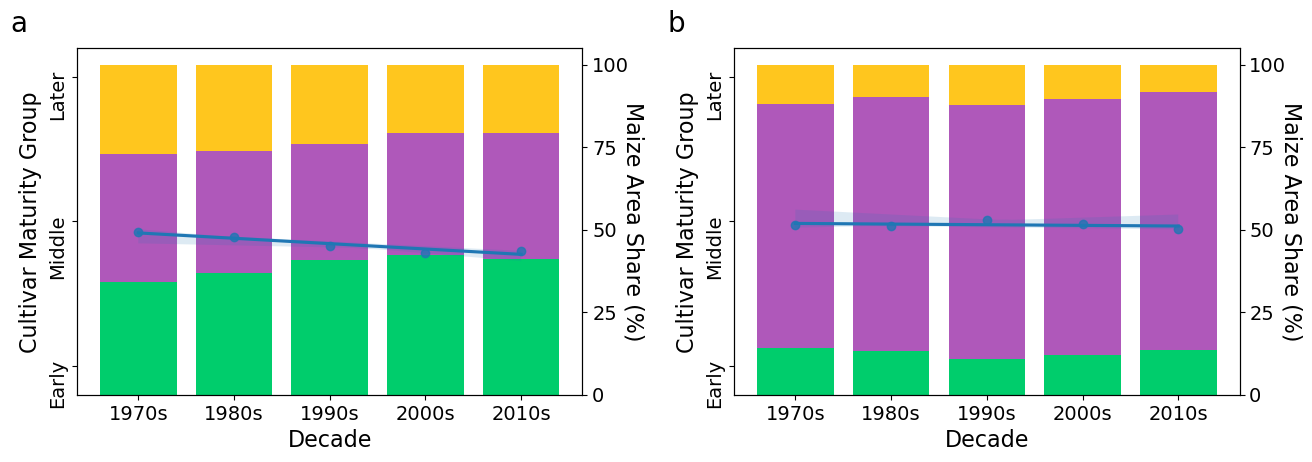

In [781]:
#Plotting
fig, ax = plt.subplots(1, 2, figsize=(15,4.5))
colors=["#00CD6C", "#AF58BA", "#FFC61E"]
for se in range(2):
    period=["se"+str(se+1)+"c_"+str(p) for p in range(5)]
    data=pd.DataFrame(columns=['culvalue','E','M','L'])
    temp=df_area[period+['A']].fillna(0)
    data['culvalue']=[sum(temp[c]*temp['A'])/temp['A'].sum() for c in temp.columns[:5]]
    for p in range(5):
        data.iloc[p,1:]=(temp[[period[p],'A']].groupby(period[p]).sum()*100/temp['A'].sum()).reset_index()['A'].tolist()

    ax1=ax[se].twinx()
    #Bar
    ax[se].bar(list(range(5)),data["E"].values,color=colors[0],label='Early')
    ax[se].bar(list(range(5)),data["M"].values,bottom=data['E'].values,color=colors[1],label="Middle")
    ax[se].bar(list(range(5)),data["L"].values,bottom=data[['E','M']].sum(1).values,color=colors[2],label="Later")

    sns.regplot(x=list(range(5)),y=data['culvalue'].tolist(),ax=ax1)
    ax[se].yaxis.set_ticks_position('right')
    ax1.yaxis.set_ticks_position('left')
    ax1.set_ylim([-1.2,1.2])
    ax1.set_yticks([-1,0,1],["Early","Middle","Later"],rotation=90,fontsize=14)
    #ax1.set_yticklabels(["Early","Middle","Later"],rotation=90)
    ax[se].set_yticks([0,25,50,75,100])
    ax1.set_ylabel("Maize Area Share (%)",fontsize=16, rotation=-90, labelpad=45)
    ax[se].set_ylabel("Cultivar Maturity Group",fontsize=16,labelpad=25)
    ax[se].set_xticks([0,1,2,3,4],["1970s","1980s","1990s","2000s","2010s"])
    ax[se].set_xlabel("Decade", fontsize=16)
    ax[se].tick_params(axis='both', which='major', labelsize=14)
    ax[se].text(ax[se].get_xlim()[0]-0.7,ax[se].get_ylim()[1]+5,chr(97+se),fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.1)  

# PLOT 3 - DISTRIBUTION OF MAIZE CULTIVAR MATURITY AND MIGRATION

In [ ]:
"""
Plot 3 - Distribution of maize cultivar maturity in Africa a) and c) Primary and second maize 
         Static cultivar maturity distribution and dominant sowing month
         with Y^2/100*SD for 50 years as the criteria 
         Culitivar maturity migration b) and d) Primary and second maize
"""

In [1055]:
#merge data and save as a tiff file
#function to transfer csv to tif file
def csv2tif(csvinput,outtif,lon_col='x',lat_col='y',value_col='value'):
    """
    Convert a csv file with latitude, longitude and value columns to a GeoTIFF
    """
    df=pd.read_csv(csvinput)
    lons=df[lon_col].values
    lats=df[lat_col].values
    values=df[value_col].values
    df=df.dropna() #remove rows with NaN values in latitude, longitude or value
    min_lon,max_lon=np.min(lons),np.max(lons)
    min_lat,max_lat=np.min(lats),np.max(lats)
    resolution=0.1 #define resolution
    rows=int((max_lat-min_lat)/resolution)+1 #create the output raster
    cols=int((max_lon-min_lon)/resolution)+1
   
    raster=np.full((rows,cols),np.nan) #Initialize with NaN values
    #Populate the raster based on dataframe values
    for lat,lon,value in zip(lats,lons,values):
        col=int((lon-min_lon)/resolution)
        row=int((max_lat-lat)/resolution)
        if 0<=row<rows and 0<=col<cols: #check bounds
            raster[row,col]=value
    transform=from_origin(min_lon,max_lat,resolution,resolution) #create transform
    #Write the raster to a GeoTIFF file
    with rasterio.open(
            outtif,
            'w',
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=rasterio.float32, #Use float32 to stor NaN values
            crs='EPSG:4326',     #Geographic coordinate system
            transform=transform
            ) as dst:
                dst.write(raster,1)

In [1166]:
#Convert cultivar maturity distribution (mean) to tif files
crop="mz"
data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")
#df<-read.csv(gridfile,header=T)
infile="D:/works/AfricaMzSg/results/"+crop+"/"+crop+"_culseg_1971-2021_GT1.csv"
temp=pd.read_csv(infile)
data=data.merge(temp,on="SIMUNIT",how="inner")[['POINT_X','POINT_Y','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
data.columns=['x','y','s1c','s1m','s2c','s2m']
#save column value as a tiff file
#Export result as tif raster
for se in ['s1c','s2c']:
    df=data[['x','y',se]]
    df.columns=['x','y','value']
    df=df.dropna()
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"_se"+se[1]+"_dis.csv",index=False)
    csv2tif("D:/works/AfricaMzSg/results/"+crop+"_se"+se[1]+"_dis.csv","D:/works/AfricaMzSg/results/"+crop+"_se"+se[1]+"_dis.tiff")

In [1066]:
#Convert cultivar maturity migraation to tif files 
#Get the information where has migration and latitude and longitude
#-1: to early, 0: no change, 1: to later
def create_new_column(row):
    if np.isnan(row[0]) or np.isnan(row[1]):
        return np.nan
    else:
        if row[0] > 0 and row[1] <= 0.1:
            return 1
        elif row[0] < 0 and row[1] <= 0.1:
            return -1
        else:
            return 0
temp=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"_cul_temporalChange.csv")[['SIMUNIT','slope_1','pvalue_1','slope_2','pvalue_2']]
temp['se1'] = temp[['slope_1','pvalue_1']].apply(create_new_column, axis=1)
temp['se2'] = temp[['slope_2','pvalue_2']].apply(create_new_column, axis=1)
temp=temp[['SIMUNIT','se1','se2']]
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','POINT_X','POINT_Y','A']]
df.columns=['SIMUNIT','x','y','A']
df=df.merge(temp)
#save it as a tif
for se in ['se1','se2']:
    temp=df[['x','y',se]]
    temp.columns=['x','y','value']
    temp=temp.dropna()
    temp.to_csv("D:/works/AfricaMzSg/results/"+crop+"_"+se+"_change.csv",index=False)
    csv2tif("D:/works/AfricaMzSg/results/"+crop+"_"+se+"_change.csv","D:/works/AfricaMzSg/results/"+crop+"_"+se+"_change.tiff")

In [1450]:
"""
Plotting
"""
tif_dir="D:\\works\\AfricaMzSg\\results\\"
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
#Define color
type_colors = [{-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"},{-1: "red", 0: "lightgrey", 1: "green"}] #blue, red, green, maturity type 
change_colors = {-1: "red", 0: "lightgrey", 1: "blue"} #change
#African country bounday
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
africa=africa[africa['CONTINENT']=='Africa']
#type_colors = {-1: "#E9002D", 0: "#FFAA00", 1: "#00B000"}  #Red Amber Green
tif_type=['dis','change']
pie_title=['Area share (%)\n of maturity group','Area share (%)\n of maturity migration']
pie_label=[['Early','Middle','Later'],['To early','No change','To later']]
pie_radius=[0.9,0.9]
#grid include maize area
grid=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['POINT_X','POINT_Y','A']]
grid.columns=['x','y','A']

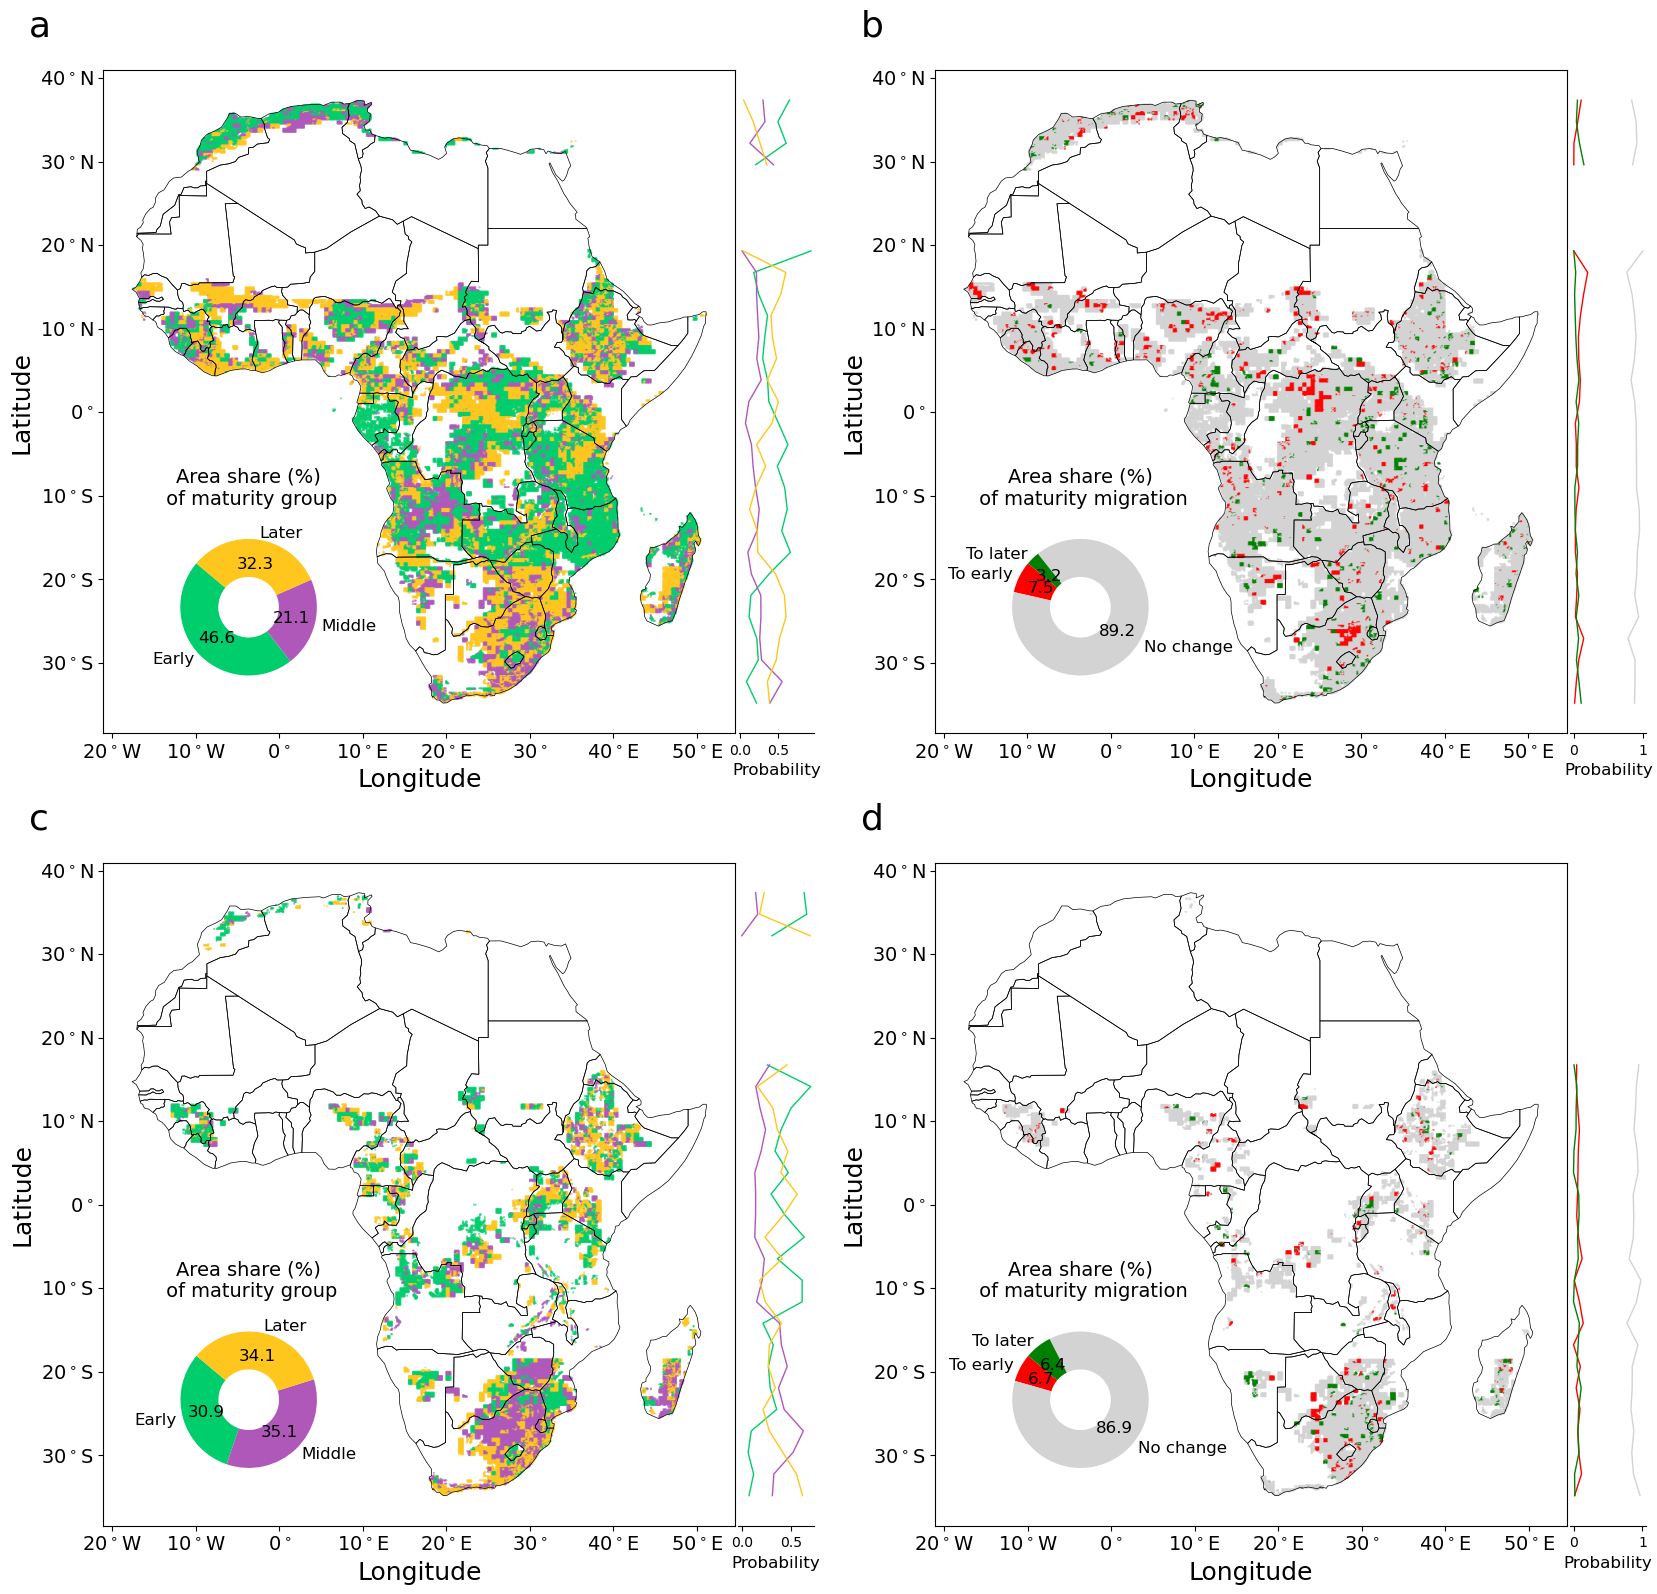

In [1455]:
fig, axs = plt.subplots(2,2,figsize=(16.8,16))
#axs.axis("off") 
for i,j in list(itertools.product(range(2),range(2))):  #i=season, j=dist or change
    tif=tif_dir+"mz_se"+str(i+1)+"_"+tif_type[j]+".tiff"  #tif file for plotting
    df=pd.read_csv(tif_dir+"mz_se"+str(i+1)+"_"+tif_type[j]+".csv") #data file for computer area sharing
    df=df.merge(grid).dropna()[['value','A']] #only leave value and Area columns
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")
       
    #main distribution plot at the middle
    ax_main = axs[i,j]
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([type_colors[j][-1],type_colors[j][0],type_colors[j][1]]),
        #legend=True,
        markersize=0.1-
    )
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=18)
    ax_main.set_ylabel("Latitude", fontsize=18)
    ax_main.set_xticks([-20,-10,0,10,20,30,40,50],
                       ['$20^\circ$W','$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E','$50^\circ$E'],fontsize=14)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30,40],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N','$40^\circ$N'],fontsize=14)
    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.08,0.04,0.3,0.3])   
    sizes = (df.groupby('value').sum()*100/df['A'].sum()).reset_index()['A'].tolist() #[-1,0,1]
    ax_pie.pie(sizes, 
               labels=pie_label[j],  #
               textprops={'fontsize': 12},
               radius=pie_radius[i],
               colors=[type_colors[j][-1],type_colors[j][0],type_colors[j][1]], 
               autopct=lambda pct: f'{pct:.1f}',
               pctdistance=0.65, 
               labeldistance=1.1, 
               rotatelabels=False,
               wedgeprops=dict(width=0.5),
               startangle=-220)
               #autopct=lambda pct: f'{pct:.1f}', startangle=90, wedgeprops=dict(width=0.5))  #'%1.0f%%'
    ax_pie.set_title(pie_title[j],fontsize=14)
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])
    
     #KDE plt at right
    ax_dist = ax_main.inset_axes([1.005,0,0.12,1])
    
    latitude_bins = np.linspace(data["latitude"].min(), data["latitude"].max(), 30)
    data["latitude_bins"]=pd.cut(data["latitude"],bins=latitude_bins,include_lowest=True)
    p_table=data.groupby(['latitude_bins','value']).size().unstack(fill_value=0)
    p_table=p_table.div(p_table.sum(axis=1),axis=0)
    c_p=p_table.cumsum(axis=1)

    for value in [-1,0,1]:
        ax_dist.plot(p_table[value],
                    latitude_bins[:-1]+np.diff(latitude_bins)/2,
                    linewidth=1,
                    color=type_colors[j][value])
    ax_dist.set_yticks([])
    #ax_dist.set_xticks([0,0.05])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    ax_dist.set_xlabel("Probability",fontsize=12)
for i in range(4):axs[i//2,i%2].text(-30,45,chr(97+i),fontsize=26)

plt.subplots_adjust(wspace=0.03,hspace=0.16)      
fig.tight_layout()
plt.show()
fig.savefig(fig_dir+"MS1_mz_cul_distribution_change.png",format="png",dpi=300)
fig.savefig(fig_dir+"MS1_mz_cul_distribution_change.pdf",format="pdf",dpi=300)

# FIG 4 - SEED SEGMENTATION AND BENEFITS

In [ ]:
"""
Plot 4 - Cultivar segmentation and its benefits to maize production
         4a. left: potential benefits by optimizing seed
             right:relationsip between number of segmented market and changes in prodution (Season 1)
         4b. the best segmentation scenario
         4c. which country has the highest benefits from market segmentation
"""

In [ ]:
#Segment market for season 1 - identify the best segmentation parameters
#Info 1 - Find out the optimum setting for segmentation to maximum yield and minimum cv - relationship between parameters - mean/cv
#Info 2 - Segmenation for season 1 maize
#Info 3 - Sgementation distribution between maturity groups
#Info 4 - Segmentation hotspot countries
#Info 5 - Segmentation hotspot regions
crop="mz"
data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")
data['sea1_rai_sowmon']=data['ISIMIP_se1_sow']//30
#df<-read.csv(gridfile,header=T)
infile="D:/works/AfricaMzSg/results/"+crop+"/"+crop+"_culseg_1971-2021_GT1.csv"
temp=pd.read_csv(infile)
data=data.merge(temp,on="SIMUNIT",how="inner")[['SIMUNIT','POINT_X','POINT_Y','A','sea1_rai_sowmon','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
data.columns=['SIMUNIT','x','y','A','s1sowm','s1c','s1m','s2c','s2m']

#Here only plot first season
df=data[['SIMUNIT','x','y','s1c','s1m','A','s1sowm']].dropna()

es=[round(x,1) for x in np.arange(0.1,5.1,0.1).tolist()] #granularity of the cluster, samller values create more clusters
ms=list(range(10,200,10))#[50,100,150,200,250,300] #density threshold higher values result in fewer clusters
para=list(itertools.product(es,ms))

coordinates=df[['x','y','s1c']].values
#Apply DBSCAN clustering
#Adjust eps (distance threshold) and min_samples (minimum points in a cluster) as needed
for p in range(len(para)):
    dbscan=DBSCAN(eps=para[p][0],min_samples=para[p][1])
    cluster=dbscan.fit_predict(coordinates)
    num_clusters=len(set(cluster)-{-1})
    df['es'+str(para[p][0])+'_ms'+str(para[p][1])+'_cl'+str(num_clusters)]=cluster
    #number of clusters(exclusding noise, which is labeled as -1)
df.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se1_cul_cluster_1971-2021.csv", index=False)

In [ ]:
#Compute aggregated season1 production based on seed segmentation parameters
def FindOptimCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values #
    mean=group0[:,:51].mean(1)
    std=group0[:,:51].std(1)
    index=np.argmax(mean**2/100*std)
    return group0[index]
def FindMeanCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.mean(axis=0)
def IdentifyCulGroup(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    s1c=int(group.s1c.values[0])
    if s1c>1:
        return group0.mean(axis=0)#.tolist() #if cultivar is not -1,0,1, take the mean of three
    else:
        return group0[s1c+1]#.tolist()  
seed_optim=['Seed_ThreeMean','Seed_FixedOptim','Seed_DecadeOptim','Seed_YearOptim'] #select Seed_FixedOptim
sowing_window=['ReportedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow'] #Select OptimumFixedSow
in_dir="D:\\works\\AfricaMzSg\\output\\"
seedOp=seed_optim[1] #Seed_FixedOptim
seedWn=sowing_window[1] #OptimumFixedSow
#Seed segmentation approach

for season in [1,2]:
    seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
    #Drop columns that contain the string 'cl0 - cl3' - remove 0 cluster columns
    seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']
            +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
    A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index() #maize Area for simunit
    #Yield file
    yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
    yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
    #Output dataframe
    result=pd.DataFrame(columns=['es','ms','cul','prod_mean','prod_cv','neg1areashare'])
    #To explore differennt setting and identify the best segmentation stratgies
    for col in seg.columns[4:]:
        line=[float(x[2:]) for x in col.split('_')]  #es,ms,cl
        missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
        temp=seg[['s'+str(season)+'c',col]].groupby(col)['s'+str(season)+'c'].agg(mode).reset_index() #find dominant maturity group for each cluster
        df=seg[['SIMUNIT',col]].merge(temp)#.drop(col,axis=1) merge by cluster id
        df.loc[df[col]==-1,'s'+str(season)+'c']=5 #provide cultivar number 5 to cluster -1, grids can not be clustered.
        df=df.groupby('SIMUNIT')['s'+str(season)+'c'].agg(mode).reset_index() #for grids with the identical SIMUNIT, take the same cultivar type
        df=df.merge(A) #merge maize area
        df=yld.merge(df) #merge to yield
        temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()
        df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
        df.fillna(0,inplace=True)
        prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])
        result.loc[len(result)]=line+[prod.mean(),prod.std()*100/prod.mean(),missclusterarea]
#reference prod
#if season==1:
#    result.loc[len(result)]=[0,0,1,82364029,4.04,0] #where does this 82364029 come from?
#else:
#    result.loc[len(result)]=[0,0,1,82364029,4.04,0]
#result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"se"+str(season)+"_Prodution_Sensitivity_to_culSeg_1971-2021.csv", index=False)

In [1221]:
"""
Identify simulated production reference
"""

'\nIdentify simulated production reference\n'

In [1212]:
seedWn='FixedSow'

In [1216]:
def FindOptimCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values #
    mean=group0[:,:51].mean(1)
    std=group0[:,:51].std(1)
    index=np.argmax(mean**2/100*std)
    return group0[index]
def FindMeanCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.mean(axis=0)
season=1
yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
yld=yld.merge(df)
temp=yld.groupby('SIMUNIT').apply(FindMeanCulYld).reset_index()#
df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
df.fillna(0,inplace=True)
#prod=np.dot(df.loc[:,["yld_"+str(yr) for yr in range(1971,2022)]].T,df.loc[:,'A'])        
prod=np.dot(df.iloc[:,:51].T,df.iloc[:,51])

In [1218]:
seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
#Drop columns that contain the string 'cl0 - cl3' - remove 0 cluster columns
seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']]
#        +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
A=A[(A['SIMUNIT']>0)&(A['A']>0)].reset_index() #maize Area for simunit
#Yield file
yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
yld=yld.merge(A)
temp=yld.groupby('SIMUNIT').apply(FindMeanCulYld).reset_index() #
df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
df.fillna(0,inplace=True)
#prod=np.dot(df.loc[:,["yld_"+str(yr) for yr in range(1971,2022)]].T,df.loc[:,'A'])        
prod=np.dot(df.iloc[:,:51].T,df.iloc[:,51])
[np.mean(prod),100*np.std(prod)/np.mean(prod)]

[87728124.01030731, 3.850552949638188]

In [1217]:
[np.mean(prod),100*np.std(prod)/np.mean(prod)]

[89214803.02374281, 3.815033351468881]

In [1181]:
[np.mean(prod),100*np.std(prod)/np.mean(prod)]  #mean - reference

[89854962.0092394, 4.099898395048961]

In [1194]:
[np.mean(prod),100*np.std(prod)/np.mean(prod)]

[94309333.08933197, 4.88632479426969]

In [1210]:
    seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
    #Drop columns that contain the string 'cl0 - cl3' - remove 0 cluster columns
    seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']
            +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
    A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index() #maize Area for simunit
    #Yield file
    yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
    yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1

    #Output dataframe
    result=pd.DataFrame(columns=['es','ms','cul','prod_mean','prod_cv','neg1areashare'])
    #To explore differennt setting and identify the best segmentation stratgies
    col=seg.columns[4]
    line=[float(x[2:]) for x in col.split('_')]  #es,ms,cl
    missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
    temp=seg[['s'+str(season)+'c',col]].groupby(col)['s'+str(season)+'c'].agg(mode).reset_index() #find dominant maturity group for each cluster
    df=seg[['SIMUNIT',col]].merge(temp)#.drop(col,axis=1) merge by cluster id
    df.loc[df[col]==-1,'s'+str(season)+'c']=5 #provide cultivar number 5 to cluster -1, grids can not be clustered.
    df=df.groupby('SIMUNIT')['s'+str(season)+'c'].agg(mode).reset_index() #for grids with the identical SIMUNIT, take the same cultivar type
    df=df.merge(A) #merge maize area
    df=yld.merge(df) #merge to yield
    temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()
    df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
    df.fillna(0,inplace=True)
    prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])
    [np.mean(prod),100*np.std(prod)/np.mean(prod)]

[87727170.38049507, 3.7451627279585926]

In [1164]:
seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
#Drop columns that contain the string 'cl0 - cl3' - remove 0 cluster columns
seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']
        +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index() #maize Area for simunit
#Yield file
yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
#Output dataframe
result=pd.DataFrame(columns=['es','ms','cul','prod_mean','prod_cv','neg1areashare'])
#To explore differennt setting and identify the best segmentation stratgies
for col in seg.columns[4:]:
    line=[float(x[2:]) for x in col.split('_')]  #es,ms,cl
    missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
    temp=seg[['s'+str(season)+'c',col]].groupby(col)['s'+str(season)+'c'].agg(mode).reset_index() #find dominant maturity group for each cluster
    df=seg[['SIMUNIT',col]].merge(temp)#.drop(col,axis=1) merge by cluster id
    df.loc[df[col]==-1,'s'+str(season)+'c']=5 #provide cultivar number 5 to cluster -1, grids can not be clustered.
    df=df.groupby('SIMUNIT')['s'+str(season)+'c'].agg(mode).reset_index() #for grids with the identical SIMUNIT, take the same cultivar type
    df=df.merge(A) #merge maize area
    df=yld.merge(df) #merge to yield
    temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()
    df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
    df.fillna(0,inplace=True)
    prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])
    result.loc[len(result)]=line+[prod.mean(),prod.std()*100/prod.mean(),missclusterarea]

array([1.00850769e+08, 1.00372418e+08, 9.44557834e+07, 9.92120110e+07,
       9.58414078e+07, 9.77829394e+07, 9.61340909e+07, 1.00387863e+08,
       9.78085697e+07, 9.64631800e+07, 9.64867604e+07, 9.82965483e+07,
       8.64023387e+07, 8.66033792e+07, 8.95741204e+07, 1.02150505e+08,
       9.57177570e+07, 8.79897038e+07, 1.00083736e+08, 9.77397132e+07,
       8.52161129e+07, 8.13322306e+07, 9.59188795e+07, 8.73886069e+07,
       9.65965186e+07, 9.15915656e+07, 9.08345102e+07, 9.71123236e+07,
       9.54160173e+07, 9.21097175e+07, 9.30416438e+07, 9.14529750e+07,
       8.98409601e+07, 8.89799669e+07, 8.59009623e+07, 9.07669264e+07,
       9.75004854e+07, 9.17839312e+07, 9.75344444e+07, 9.68064540e+07,
       9.78047007e+07, 9.27555511e+07, 9.71041402e+07, 9.64268911e+07,
       9.24168192e+07, 9.47626565e+07, 9.83131729e+07, 9.89875273e+07,
       9.19014037e+07, 9.60464913e+07, 9.57778065e+07])

In [782]:
#Yield table for potential yield benefits of cultivar and sow
colnames=['meanProdReportedSow_se1','meanProdReportedSow_se2','FAO2011-2022',
          'meanProdOptimFixedSow_se1','meanProdOptimFixedSow_se2','optimSeedProdOptimFixedSow_se1','optimSeedProdOptimFixedSow_se2',
          'optimSeedProdOptimSow_se1','optimSeedProdOptimSow_se2']
potentialbeni=pd.DataFrame(columns=colnames)
#MaizeArea
A=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
A=A[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
A=A[(A['SIMUNIT']>0)&(A['A']>0)].reset_index(drop=True)
#meanProdReportedSow and meanProdOptimFixedSow
df=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_allgrids_Production.csv") #This table use for all mean production
#meanProdReportedSow_Sea1
potentialbeni['meanProdReportedSow_se1']=df[(df['sowingwindow']=='ReportedSow')&(df['type']=='mean')
   &(df['sea']==1)][[str(x) for x in range(1971,2022)]].mean().tolist()
#meanProdReportedSow_Sea2
potentialbeni['meanProdReportedSow_se2']=df[(df['sowingwindow']=='ReportedSow')&(df['type']=='mean')
   &(df['sea']==2)][[str(x) for x in range(1971,2022)]].mean().tolist()
#meanProdOptimFixedSow_Se1
potentialbeni['meanProdOptimFixedSow_se1']=df[(df['sowingwindow']=='OptimumFixedSow')&(df['type']=='mean')
   &(df['sea']==1)][[str(x) for x in range(1971,2022)]].mean().tolist()
potentialbeni['meanProdOptimFixedSow_se2']=df[(df['sowingwindow']=='OptimumFixedSow')&(df['type']=='mean')
   &(df['sea']==2)][[str(x) for x in range(1971,2022)]].mean().tolist()
#FAO 2017-2021
df=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\FAOSTAT_mz_2011-2023_202501116.csv")
potentialbeni.loc[45:49,'FAO2011-2022']=df[(df.Element=="Production")&(df.Year>2016)&(df.Year<2022)]['Value'].tolist()
#'optimSeedProdOptimFixedSow_se1','optimSeedProdOptimFixedSow_se2'
df=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_OptimumFixedSow.txt",delim_whitespace=True)
for se in [1,2]:
    temp=df[df.sea==se].groupby('SIMUNIT').max().reset_index().merge(A).fillna(0)
    potentialbeni['optimSeedProdOptimFixedSow_se'+str(se)]=np.dot(temp.A.T,temp[["yld_"+str(i) for i in range(1971,2022)]])
#'optimSeedProdOptimSow_se1','optimSeedProdOptimSow_se2'
df=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_OptimumYearSow.txt",delim_whitespace=True)
for se in [1,2]:
    temp=df[df.sea==se].groupby('SIMUNIT').max().reset_index().merge(A).fillna(0)
    potentialbeni['optimSeedProdOptimSow_se'+str(se)]=np.dot(temp.A.T,temp[["yld_"+str(i) for i in range(1971,2022)]])
potentialbeni.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\potentialBenfitsfromSeedOptimAndSow.csv", index=False)   

In [964]:
"""
Plotting - Production benefits from maize maturity optimization and market segmentation
         a. Potential production benefits from maize cultivar maturity optimization
            Boxplots: - meanProdReportedSow
                      - FAO (2000) 
                      - MeanProdOptimFixedSow (Ref) 
                      - OptimSeedOptimFixedSow (Target) 
                      - OptimSeedOptimSow
         b. Relationship between number of market and benefits on production for primary season maizem
            Changes are compared between Production with optimumFixedSow and seed segmentation and the Ref production
"""
import matplotlib.patches as patches

In [898]:
#Fig 4a - potential production benefits from maize matrity optimization
potentialbeni=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\potentialBenfitsfromSeedOptimAndSow.csv")
culsen=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\Prodution_Sensitivity_to_culSeg_1971-2021.csv")
potentialbeni=potentialbeni/1000000
ref=culsen.shape[0]-1
culsen['prod_ch']=100*(culsen['prod_mean']-culsen['prod_mean'][ref])/culsen['prod_mean'][ref]
culsen['cv_ch']=100*(culsen['prod_cv']-culsen['prod_cv'][ref])/culsen['prod_cv'][ref]

In [ ]:
from matplotlib.gridspec import GridSpec

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15588\1282410257.py:38: RuntimeWarning: invalid value encountered in scalar power
  return -a*(x**n)/((k**n)+(x**n))


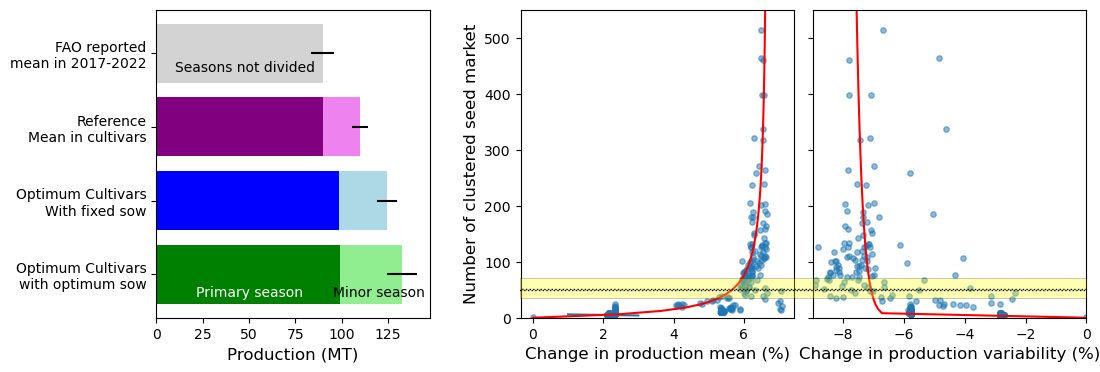

In [1081]:
# Create a figure with GridSpec
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Bar potential benefits
bar=ax1.barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se1'].mean(),color='green')
ax1.barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimSow_se1','optimSeedProdOptimSow_se1']].sum(axis=1).std(),
            color='lightgreen')
ax1.text(50,-0.25,'Primary season',ha='center',va='center',color='white')
ax1.text(120,-0.25,'Minor season',ha='center',va='center',color='black')

ax1.barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),color='blue')
ax1.barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimFixedSow_se1','optimSeedProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='lightblue')

ax1.barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se1'].mean(),color='purple')
ax1.barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['meanProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['meanProdOptimFixedSow_se1','meanProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='violet')
ax1.barh("FAO reported\nmean in 2017-2022",potentialbeni['FAO2011-2022'].mean(),
            xerr=potentialbeni['FAO2011-2022'].std(),color='lightgrey')
ax1.set_xlabel("Production (MT)",fontsize=12)
ax1.text(10,2.75,'Seasons not divided', color='black')

#Scatter and fit line - production benefits with market segmentation
ax2.plot([1, 2, 3], [6, 5, 4])
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return -a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['prod_ch']
popt, pcov = curve_fit(func, xdata, ydata)  # Fit the curve
a, n, k = popt # Extract the optimized parameters
ax2.scatter(ydata, xdata, label='Data',s=15,alpha=0.5) # Extract the optimized parameters
x_fit = np.linspace(0, 600, 100)
ax2.plot(func(x_fit, -6.7, n, k), x_fit, 'r-', label='Fit')
ax2.set_ylim([0,550])
ax2.set_xlabel("Change in production mean (%)",fontsize=12)
ax2.set_ylabel("Number of clustered seed market",fontsize=12)

#Scatter and fit line - cv benefit with martket segmentation
ax3.plot([1, 2, 3], [5, 5, 5])
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['cv_ch']
popt, pcov = curve_fit(func, xdata, ydata)# Fit the curve
a, n, k = popt# Extract the optimized parameters
ax3.scatter(ydata, xdata, label='Data',s=15,alpha=0.5)
x_fit = np.linspace(0, 800, 100)
ax3.plot(func(x_fit, -16.0, 0.05,5000), x_fit, 'r-', label='Fit')
ax3.set_xlim([-9,0])
ax3.set_ylim([0,550])
ax3.set_yticklabels([])
ax3.set_xlabel("Change in production variability (%)",fontsize=12)
gs.update(wspace=0.2)  # Increase overall spacing
ax2.set_position([ax2.get_position().x0 + 0.03, ax2.get_position().y0, 
                  ax2.get_position().width, ax2.get_position().height])  # Shift middle subplot

#Add yellow box for choosing the cluster parameters and number of market
rect = patches.Rectangle((0.428, 0.16), 0.472, 0.05, transform=fig.transFigure, 
                         linewidth=0.5, edgecolor='black', facecolor='yellow',alpha=0.3)
fig.add_artist(rect)
rect = patches.Rectangle((0.428, 0.18), 0.472, 0.001, transform=fig.transFigure, 
                         linewidth=1,linestyle=':', edgecolor='black', facecolor='none')
fig.add_artist(rect)

plt.show()

In [33]:
"""
Plotting - the best scenario of market segmenation
         a. Market for maize maturity group in Primary and Minor seasons
         b. Countries benefits (prod up, cv down) and costs (harmanized(nMartket/Pop) from the segmentation 
"""
G1="_GT1"
crop="mz"
fer="wfer_wa40hi45"
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")

In [ ]:
#plot market segmentation of its production benefits

In [141]:
import numpy as np
import geopandas as gpd

In [94]:
from statistics import mode

In [50]:
def IdentifyCulGroup(group):
    c=group['c'].tolist()[0]  #c=str(int(group['c'][0])).replace("-",".")
    m=group['m'].tolist()[0]  #m=str(int(group['m'][0])).zfill(2)
    a=group['A'].mean()
    country=group['country'].tolist()[0]
    if m=='' or np.isnan(m):  #if there is no sowing month value
        result=[0]*51 
    else:                    #there is sowing moth value
        m=str(int(m)).zfill(2)
        if c=='' or np.isnan(c):            #no cultivar being identified
            result=group[[col for col in group.columns if 's'+m in col]].mean(axis=1).tolist()  #average across the three groups
        else:                              #month and cultivar are provided
            c=str(int(c)).replace("-",".")
            result=group.loc[:,'m'+c+'s'+m].tolist()
    return(result+[a]+[country])

In [51]:
#Estimate the benefits by country
in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")
reportedsow=reportedsow[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m','country','A']]
#temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")  #area
#reportedsow=reportedsow.merge(temp,how='left')
reportedsow.columns=['SIMUNIT','s1m','s2m','country','A']
result=pd.DataFrame(columns=['season','country','prod_wocluster','prod_cv_wocluster','prod_wcluster','prod_cv_wcluster'])

se=1
#production with out the clustering
temp=reportedsow[['SIMUNIT','s'+str(se)+'m','A','country']]  #reported month and area
temp.columns=['SIMUNIT','m','A','country']
temp.insert(1, 'c', '')                                #inset cultivar columns
df=yld.merge(temp,how='left')                          #merge to yld dataframe
temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()   #compute yearly yield
df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index]).fillna(0)  #conver the dataframe
prod=[]
prod_cv=[]
for coun in df.iloc[:,52].unique():
    temp=df[df.iloc[:,52]==coun]
    temp=np.dot(temp.iloc[:,51].T,temp.iloc[:,:51])
    prod=prod+[temp.mean()]
    prod_cv=prod_cv+[temp.std()*100/temp.mean()]
result['season']=[se]*len(df.iloc[:,52].unique())
result['country']=df.iloc[:,52].unique()
result['prod_wocluster']=prod


In [339]:
#merge data and save as a tiff file
#function to transfer csv to tif file
def csv2tif(csvinput,outtif,lon_col='x',lat_col='y',value_col='value'):
    """
    Convert a csv file with latitude, longitude and value columns to a GeoTIFF
    """
    df=csvinput#pd.read_csv(csvinput)
    lons=df[lon_col].values
    lats=df[lat_col].values
    values=df[value_col].values
    df=df.dropna() #remove rows with NaN values in latitude, longitude or value
    min_lon,max_lon=np.min(lons),np.max(lons)
    min_lat,max_lat=np.min(lats),np.max(lats)
    resolution=0.1 #define resolution
    rows=int((max_lat-min_lat)/resolution)+1 #create the output raster
    cols=int((max_lon-min_lon)/resolution)+1
   
    raster=np.full((rows,cols),np.nan) #Initialize with NaN values
    #Populate the raster based on dataframe values
    for lat,lon,value in zip(lats,lons,values):
        col=int((lon-min_lon)/resolution)
        row=int((max_lat-lat)/resolution)
        if 0<=row<rows and 0<=col<cols: #check bounds
            raster[row,col]=value
    transform=from_origin(min_lon,max_lat,resolution,resolution) #create transform
    #Write the raster to a GeoTIFF file
    with rasterio.open(
            outtif,
            'w',
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=rasterio.float32, #Use float32 to stor NaN values
            crs='EPSG:4326',     #Geographic coordinate system
            transform=transform
            ) as dst:
                dst.write(raster,1)

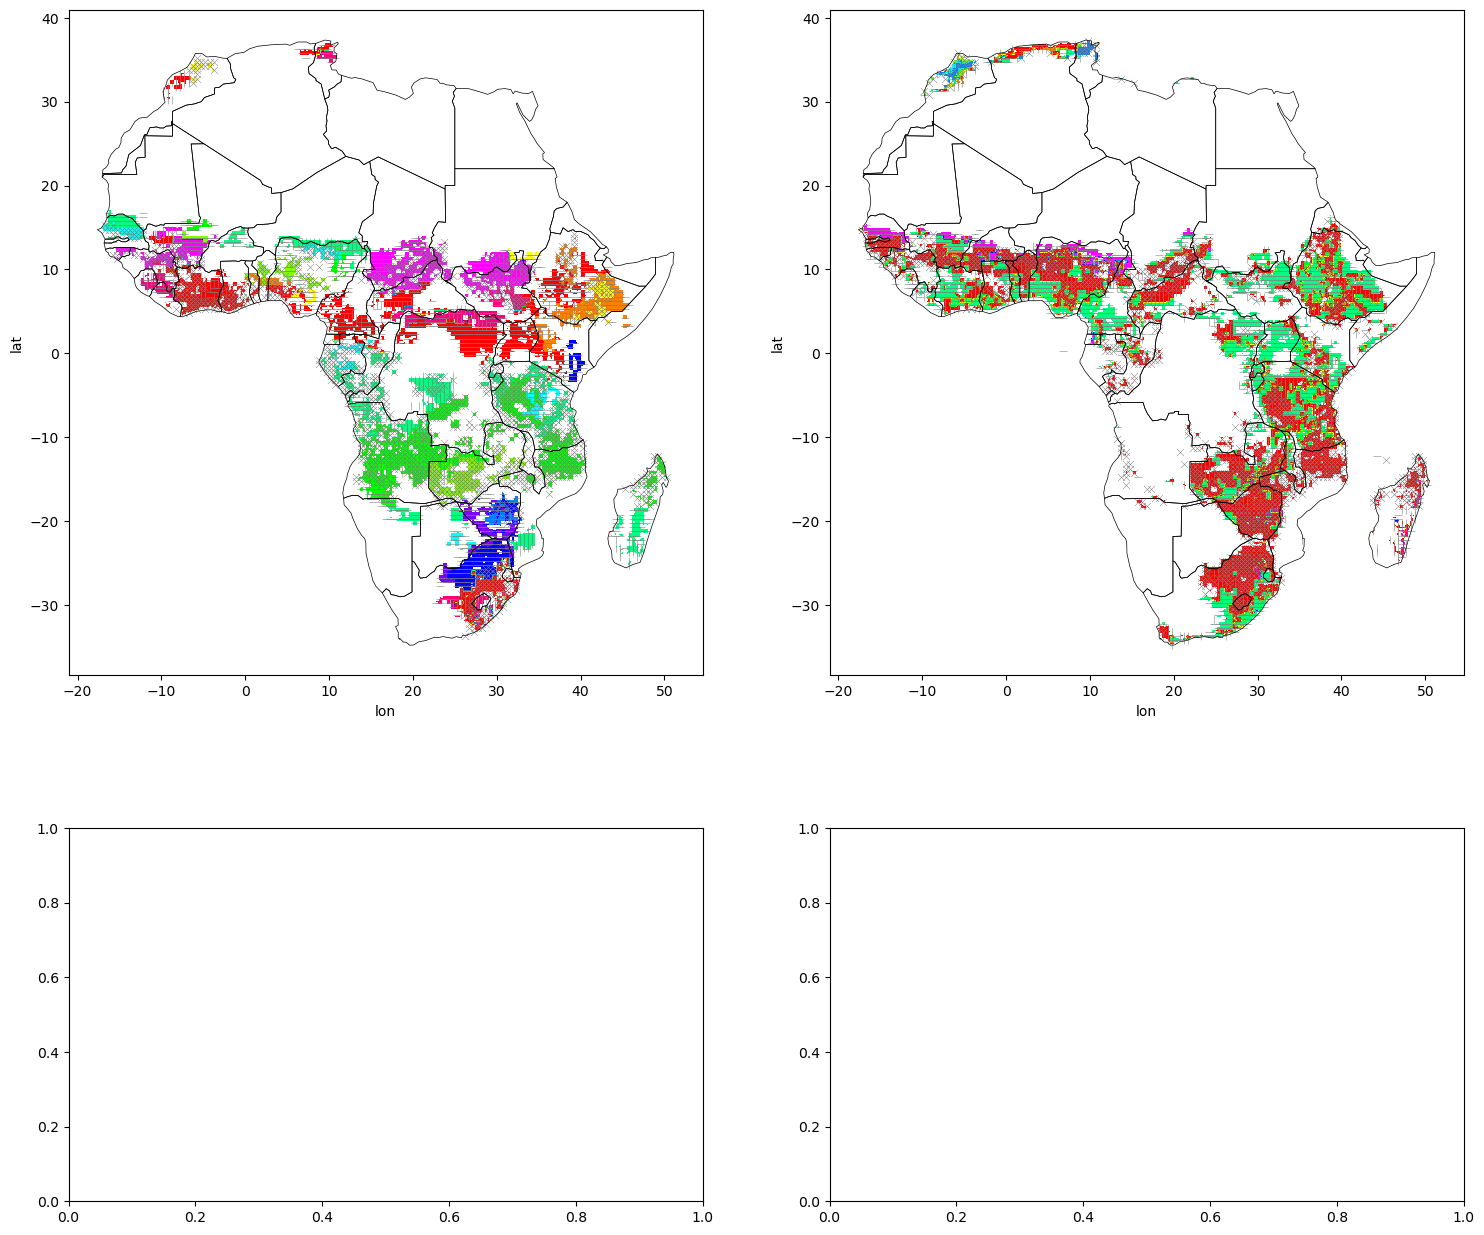

In [391]:
colors=[
    "#C0C0C0", #Silver                                                #"#FF0000", #Red
    "#FF7F00", #Organge
    "#FFFF00", #Yellow
    "#7FFF00", #Chartreuse
    "#00FF00", #Green
    "#00FF7F", #Spring Green
    "#00FFFF", #Cyan
    "#007FFF", #Azure
    "#0000FF", #Blue
    "#7F00FF", #Violet
    "#FF00FF", #Magenta
    "#FF007F", #Rose
]
#Create a ListedColormap
cmap=ListedColormap(colors)

fig, axes = plt.subplots(1,2,figsize=(18,10))  #,height_ratios=[2,1]

for se in range(2):
    #Market distribution
    #process data    
    tif="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+str(se+1)+"_Sowmon_"+fer+G1+"_dis_GT1.tiff"
    seg="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+str(se+1)+"_Domcul_"+fer+G1+"_dis_GT1.csv"
    with rasterio.open(tif) as src:
        raster_data = src.read(1)  # 读取第一个波段数据
        #get the bounds of the raster
        bounds=src.bounds
        #get the NoData value if it exists
        nodata_value=src.nodata
    img=axes[se].imshow(raster_data,cmap=cmap,vmin=1,vmax=12, extent=[bounds.left,bounds.right,bounds.bottom,
                                                                            bounds.top])
    africa.boundary.plot(ax=axes[0,se],linewidth=0.5,color='black')
    #cbar = fig.colorbar(img, ax=axes[0,0], ticks=np.arange(0,13),orientation='vertical', fraction=0.1, pad=0.05, shrink=0.5)
    #cbar.set_label('Sowing month',fontsize=14,rotation=270,labelpad=20) 
    #cbar.ax.yaxis.set_label_position('right')  #Position the label on the left
    #cbar.ax.yaxis.set_tick_params(labelsize=12) #Set the label size

    type=['x','|','_']
    size=[25,30,30]
    seg=pd.read_csv(seg)
    for cu in [-1,0,1]:
        temp=seg[seg['c']==cu]
        sns.scatterplot(
            data=temp,
            x='lon',
            y='lat',
            #hue='b', 
            color='grey',
            #    style='cluster', #Color points by cluster
            #palette='tab10',
            #label='s'+str(se),#+'m'+str(mon)
            marker=type[cu+1],  #+
            s=size[cu+1],
            #size=20,
            alpha=0.9,
            ax=axes[se])
        
    #Country benefits
    seg="in_dir+"mz_se"+str(se)+"_CountryProdBenefitByClustering_"+fer+G1+".csv"

#cbar = fig.colorbar(img, ax=axes[0,1], ticks=np.arange(0,13),orientation='vertical', fraction=0.1, pad=0.05, shrink=0.5)
#cbar.set_label('Sowing month',fontsize=14,rotation=270,labelpad=20) 
#cbar.ax.yaxis.set_label_position('right')  #Position the label on the left
#cbar.ax.yaxis.set_tick_params(labelsize=12) #Set the label size

    #Benefits across countries


In [831]:
fig, axs = plt.subplots(1,3,figsize=(14,4)) #,gridspec_kw={'width_ratios': [0.4,0.32,0.28]}
#Bar potential benefits
# Define a GridSpec layout with custom width ratios
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.3)  # Default spacing

# Create subplots
axs[0] = fig.add_subplot(gs[0, 0])  # First subplot
axs[1] = fig.add_subplot(gs[0, 1])  # Second subplot
axs[2] = fig.add_subplot(gs[0, 2])  # Third subplot


bar=axs[0].barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se1'].mean(),color='green')
axs[0].barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimSow_se1','optimSeedProdOptimSow_se1']].sum(axis=1).std(),
            color='lightgreen')
axs[0].text(50,-0.25,'Primary season',ha='center',va='center',color='white')
axs[0].text(120,-0.25,'Minor season',ha='center',va='center',color='black')

axs[0].barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),color='blue')
axs[0].barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimFixedSow_se1','optimSeedProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='lightblue')


axs[0].barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se1'].mean(),color='purple')
axs[0].barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['meanProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['meanProdOptimFixedSow_se1','meanProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='violet')


axs[0].barh("FAO reported\nmean in 2017-2022",potentialbeni['FAO2011-2022'].mean(),
            xerr=potentialbeni['FAO2011-2022'].std(),color='lightgrey')
axs[0].set_xlabel("Production (MT)",fontsize=12)
axs[0].text(10,2.75,'Seasons not divided', color='black')

#Scatter and fit line - production benefits with market segmentation
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return -a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['prod_ch']
popt, pcov = curve_fit(func, xdata, ydata)  # Fit the curve
a, n, k = popt # Extract the optimized parameters
axs[1].scatter(ydata, xdata, label='Data',s=15,alpha=0.5) # Extract the optimized parameters
x_fit = np.linspace(0, 600, 100)
axs[1].plot(func(x_fit, -6.7, n, k), x_fit, 'r-', label='Fit')
axs[1].set_ylim([0,550])
axs[1].set_xlabel("Change in production mean (%)",fontsize=12)
axs[1].set_ylabel("Number of seed market",fontsize=12)

#Scatter and fit line - cv benefit with martket segmentation
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['cv_ch']
popt, pcov = curve_fit(func, xdata, ydata)# Fit the curve
a, n, k = popt# Extract the optimized parameters
axs[2].scatter(ydata, xdata, label='Data',s=15,alpha=0.5)
x_fit = np.linspace(0, 800, 100)
axs[2].plot(func(x_fit, -16.0, 0.05,5000), x_fit, 'r-', label='Fit')
axs[2].set_xlim([-9,0])
axs[2].set_ylim([0,550])
axs[2].set_yticklabels([])
axs[2].set_xlabel("Change in production variability (%)",fontsize=12)
# Adjust spacing manually
#gs.update(wspace=0.5)  # Increase overall spacing
#axs[1].set_position([axs[1].get_position().x0 + 0.05, axs[1].get_position().y0, 
#                     axs[1].get_position().width, axs[1].get_position().height])  # Shift middle subplot
rect = patches.Rectangle((0.4, 0.16), 0.498, 0.05, transform=fig.transFigure, 
                         linewidth=0.5, edgecolor='black', facecolor='yellow',alpha=0.3)
fig.add_artist(rect)
rect = patches.Rectangle((0.4, 0.18), 0.498, 0.001, transform=fig.transFigure, 
                         linewidth=1,linestyle=':', edgecolor='black', facecolor='none')
fig.add_artist(rect)


plt.show()

[-32.51033934415841, 0.3474586344824468, 7325.019038661144]

In [1550]:
#Info 1: potential production benefits (or relative production and CV change) with best cultivar selection
#     Boxplot: 1 with optimumYearSow, 2 with optimDecadeSow, 3 with optimFixedSow 4 with ReportedSow
#     OptimFixedSow is a reference, which is used to segment seed market 
#     In theroy, how much benefit will be if cultivar maturity can be optimized, % is compared to production without optimization
#     which is the production mean across three maturity groups. 
#     FAO 2000 Production is below simulated production without cultivar optimization but higher than same optimum with reported
#     crop ladenar, indicating the importance of planting time for maize production.
sowing_window=['ReportedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:\\works\\AfricaMzSg\\output\\"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
yld=pd.read_csv(in_dir+"mz_yield_"+sowing_window[1]+".txt",delim_whitespace=True)

In [1132]:
#
yld=pd.read_csv(in_dir+"mz_yield_"+sowing_window[3]+".txt",delim_whitespace=True)
yld0=yld.groupby(["SIMUNIT","sea"]).max().reset_index()
prod1=yld0[yld0.sea==1].merge(df).fillna(0)
prod1=np.dot(prod1[["yld_"+str(x) for x in range(1971,2022)]].values.T,prod1.A.values)
prod2=yld0[yld0.sea==2].merge(df).fillna(0)
prod2=np.dot(prod2[["yld_"+str(x) for x in range(1971,2022)]].values.T,prod2.A.values)
prod=prod1+prod2
df=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_allgrids_Production.csv")
prod1=df[(df.type=="mean")&(df.sea==1)&(df.sowingwindow==sowing_window[1])][['cul']+[str(x) for x in range(1971,2022)]]
prod1=prod1[[str(x) for x in range(1997,2022)]].mean(0).values
prod2=df[(df.type=="mean")&(df.sea==2)&(df.sowingwindow==sowing_window[1])][['cul']+[str(x) for x in range(1971,2022)]]
prod2=prod2[[str(x) for x in range(1997,2022)]].mean(0).values
prod_ref=prod1+prod2
[100*(np.mean(prod)-np.mean(prod_ref))/np.mean(prod_ref),100*np.std(prod)/np.mean(prod),100*np.std(prod_ref)/np.mean(prod_ref),
np.mean(prod)**2/(100*np.std(prod)),np.mean(prod_ref)**2/(100*np.std(prod_ref))]

[-52.28249488080393,
 6.604931598891598,
 2.785737831806456,
 7920648.0630676765,
 39356010.72233891]

In [1135]:
np.mean(prod_ref)

109635527.9782

In [1136]:
def findculgroup(group):
    group0=group.iloc[:,1:].values
    mean=group0.mean(1)
    std=group0.std(1)
    index=np.argmax(mean**2/100*std)
    return group.iloc[index,1:]
yld0=yld[yld.sea==1][['SIMUNIT']+['yld_'+str(x) for x in range(1971,2022)]]
prod1=yld0.groupby('SIMUNIT').apply(findculgroup).reset_index()
prod1=prod1.merge(df)
prod1=np.dot(prod1[["yld_"+str(x) for x in range(1971,2022)]].values.T,prod1.A.values)
yld0=yld[yld.sea==2][['SIMUNIT']+['yld_'+str(x) for x in range(1971,2022)]]
prod2=yld0.groupby('SIMUNIT').apply(findculgroup).reset_index()
prod2=prod2.merge(df)
prod2=np.dot(prod2[["yld_"+str(x) for x in range(1971,2022)]].values.T,prod2.A.values)
prod=prod1+prod2

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [ ]:
[100*(np.mean(prod)-np.mean(prod_ref))/np.mean(prod_ref),100*np.std(prod)/np.mean(prod),100*np.std(prod_ref)/np.mean(prod_ref)]

In [1515]:
np.argmax(np.array([1,2,3]))

2

In [1504]:
[]

[29731897.19488954, 39356010.72233891]

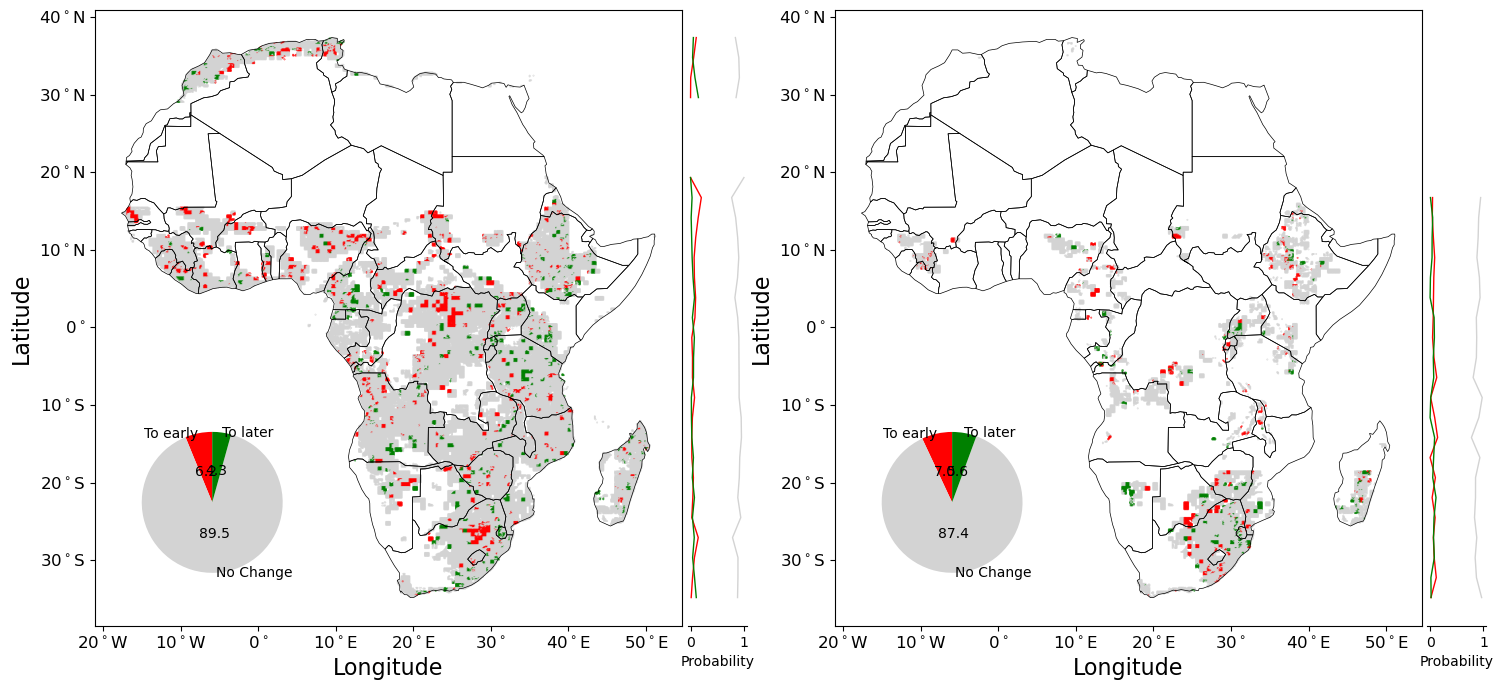

In [1419]:
tif_dir="D:\\works\\AfricaMzSg\\results\\"
change_colors = {-1: "red", 0: "lightgrey", 1: "green"}
fig, ax = plt.subplots(figsize=(17.5,8))
ax.axis("off") 
for i in range(2):
    tif=tif_dir+"mz_se"+str(i+1)+"_change.tiff"  #tif=tif_dir+"mz_s"+str(i+1)+"c_dis.tiff"
    #tif2="D:\\works\\AfricaMzSg\\results\\mz_s2c_dis.tiff"
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

    #Compute the proportion of three types of maturity
    type_counts = (data["value"].value_counts(normalize=True)*100).sort_index()
    
       
    #main distribution plot at the middle
    ax_main = fig.add_subplot(1,2,i+1)
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([change_colors[-1],change_colors[0],change_colors[1]]),
        #legend=True,
        markersize=0.1
    )
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=16)
    ax_main.set_ylabel("Latitude", fontsize=16)
    ax_main.set_xticks([-20,-10,0,10,20,30,40,50],
                       ['$20^\circ$W','$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E','$50^\circ$E'],fontsize=12)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30,40],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N','$40^\circ$N'],fontsize=12)
    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.06,0.05,0.3,0.3])

    sizes = type_counts.sort_index() #temp['A'].tolist()
    ax_pie.pie(sizes, 
               labels=['To early', 'No Change', 'To later'],
               radius=1,
               colors=[change_colors[-1],change_colors[0],change_colors[1]], 
               autopct=lambda pct: f'{pct:.1f}',pctdistance=0.45, labeldistance=1.0, startangle=90,rotatelabels=True)
               #autopct=lambda pct: f'{pct:.0f}', startangle=90, wedgeprops=dict(width=0.5))  #'%1.0f%%'

     #KDE plt at right
    ax_dist = ax_main.inset_axes([1.01,0,0.1,1])
    
    latitude_bins = np.linspace(data["latitude"].min(), data["latitude"].max(), 30)
    data["latitude_bins"]=pd.cut(data["latitude"],bins=latitude_bins,include_lowest=True)
    p_table=data.groupby(['latitude_bins','value']).size().unstack(fill_value=0)
    p_table=p_table.div(p_table.sum(axis=1),axis=0)
    c_p=p_table.cumsum(axis=1)

    for value in [-1,0,1]:
        ax_dist.plot(p_table[value],
                    latitude_bins[:-1]+np.diff(latitude_bins)/2,
                    linewidth=1,
                    color=change_colors[value])

    ax_dist.set_yticks([])
    #ax_dist.set_xticks([0,0.05])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    ax_dist.set_xlabel("Probability",fontsize=10)
    
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])

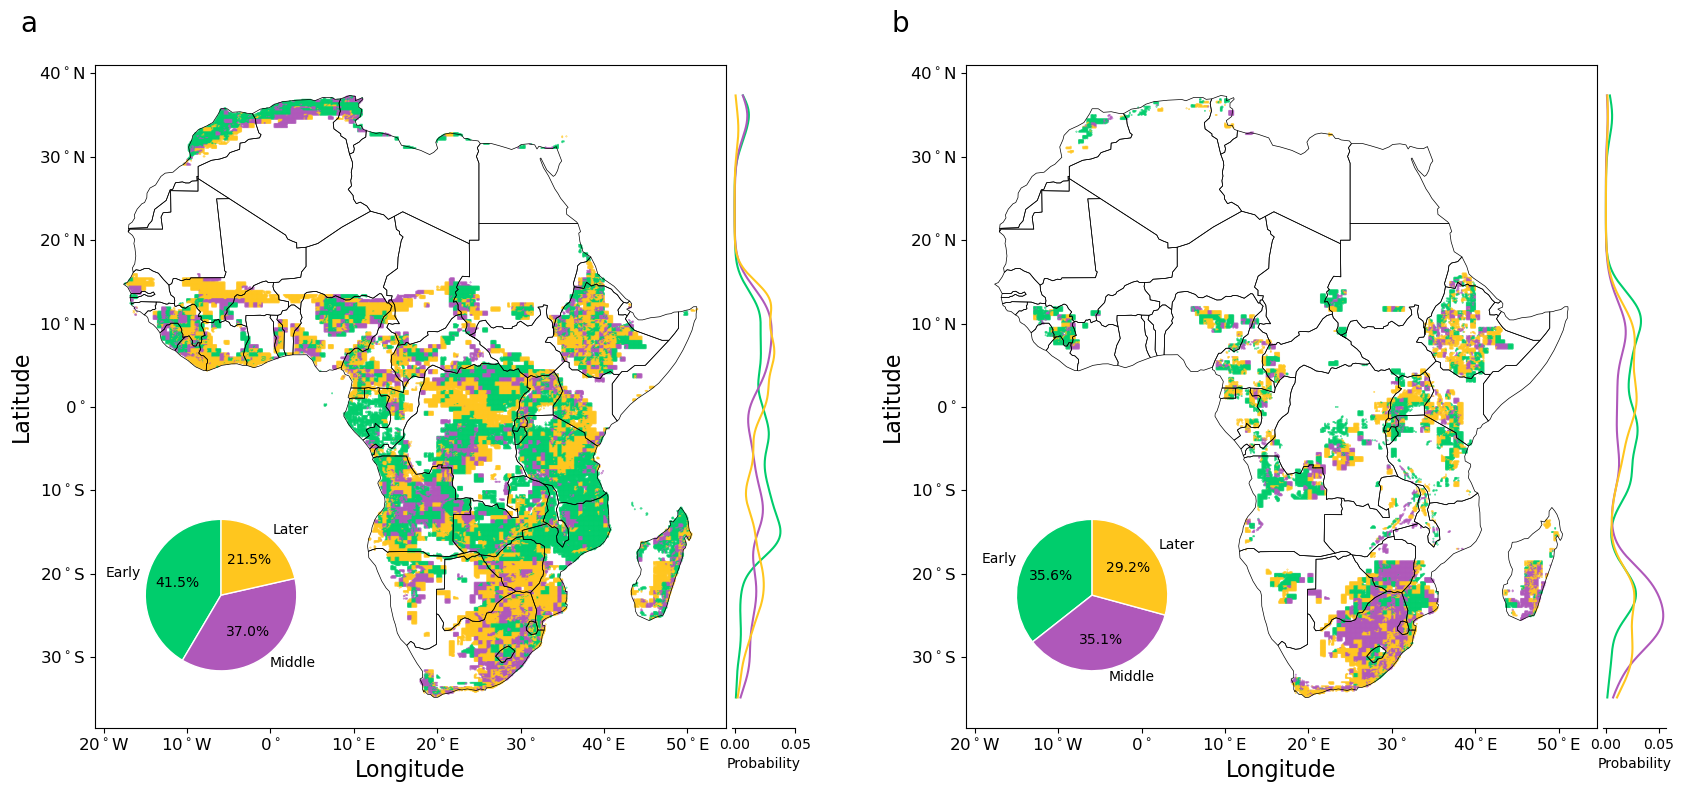

In [150]:
"""
Plotting
"""
tif_dir="D:\\works\\AfricaMzSg\\results\\"
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"
#African country bounday
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp')
africa=africa[africa['CONTINENT']=='Africa']
#Define color
type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
#type_colors = {-1: "#E9002D", 0: "#FFAA00", 1: "#00B000"}  #Red Amber Green
fig, ax = plt.subplots(figsize=(17.5,8))
ax.axis("off")  #Remove the frame, ticks and labels from the figure

#gs=fig.add_gridspec(3,6,hspace=0,wspace=0)
for i in range(2):
    tif=tif_dir+"mz_s"+str(i+1)+"c_dis.tiff"
    #tif2="D:\\works\\AfricaMzSg\\results\\mz_s2c_dis.tiff"
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

    #Compute the proportion of three types of maturity
    type_counts = data["value"].value_counts(normalize=True)*100 
    
    #Compute the probablity distribution curve
    latitude_data = []
    for maize_type in [-1,0,1]:
        latitudes = data[data["value"] == maize_type]["latitude"]
        kde = gaussian_kde(latitudes)
        lat_range = np.linspace(data["latitude"].min(), data["latitude"].max(), 500)
        latitude_data.append((maize_type,lat_range,kde(lat_range)))
    
    #main distribution plot at the middle
    ax_main = fig.add_subplot(1,2,i+1)
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([type_colors[-1],type_colors[0],type_colors[1]]),
        #legend=True,
        markersize=0.1
    )
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=16)
    ax_main.set_ylabel("Latitude", fontsize=16)
    ax_main.set_xticks([-20,-10,0,10,20,30,40,50],
                       ['$20^\circ$W','$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E','$50^\circ$E'],fontsize=12)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30,40],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N','$40^\circ$N'],fontsize=12)
    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.05,0.05,0.3,0.3])
    ax_pie.pie(
        type_counts,
        labels=["Early","Middle", "Later"],
        colors=[type_colors[-1],type_colors[0],type_colors[1]],
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor":"white"}
    )
    #ax_pie.set_title("The proportion of MG",fontsize=8)
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])
    
    #KDE plt at right
    ax_dist = ax_main.inset_axes([1.01,0,0.1,1])
    for maize_type, lat_range, density in latitude_data:
        ax_dist.plot(density,lat_range,label=f"Cultivar {maize_type}",color=type_colors[maize_type])
    #ax_dist.set_title("Distribution across latitude", fontsize=12)
    ax_dist.set_yticks([])
    ax_dist.set_xticks([0,0.05])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    #ax_dist2=ax_dist.twinx()
    #ax_dist2.set_ylabel("Probability",fontsize=16)
    #ax_dist.set_ylabel("Latitutde",fontsize=12)
    #ax_dist.legend(title="Maize maturity", fontsize=12)
    ax_dist.set_xlabel("Probability",fontsize=10)
    plt.text(-30,45,chr(97+i),fontsize=20)
fig.tight_layout()
fig.savefig(fig_dir+"MS1_mz_cul_distribution.png",format="png")
fig.savefig(fig_dir+"MS1_mz_cul_distribution.pdf",format="pdf")

In [ ]:
# 

In [827]:
period=['1971-1980','1981-1990','1991-2000','2001-2010','2011-2021']
i=0
infile=in_dir+crop+"_culseg_"+period[i]+"_GT1.csv"
df=pd.read_csv(infile)
df.columns=["SIMUNIT"]+["se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
for i in range(1,5):
    infile=in_dir+crop+"_culseg_"+period[i]+"_GT1.csv"
    temp=pd.read_csv(infile)
    temp.columns=["SIMUNIT","se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
    df=df.merge(temp)
df=df[["SIMUNIT"]+[col for col in df.columns if "se1c" in col]+[col for col in df.columns if "se2c" in col]]
for se in [1,2]:
    slope=[]
    intercept=[]
    pvalue=[]
    for rowi in range(df.shape[0]):
        y=df.iloc[rowi,(1+(se-1)*5):(6+(se-1)*5)]
        x=np.arange(len(y))
        x=sm.add_constant(x)
        model=sm.OLS(y,x)
        results=model.fit()
        slope=slope+[round(results.params[1],1)]
        intercept=intercept+[round(results.params[1],0)]
        pvalue=pvalue+[round(results.pvalues[1],3)]
    df['slope_'+str(se)]=slope
    df['intercept_'+str(se)]=intercept
    df['pvalue_'+str(se)]=pvalue
#Merge maize area for each simunit
temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
temp=temp[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df_area=df.merge(temp)
df_area=df_area[(df_area['SIMUNIT']>0)&(df_area['A']>0)]

In [903]:
fig, ax = plt.subplots(1, 2, figsize=(15,4.5))
colors=["#00CD6C", "#AF58BA", "#FFC61E"]
for se in range(2):
    period=["se"+str(se+1)+"c_"+str(p) for p in range(5)]
    data=pd.DataFrame(columns=['culvalue','E','M','L'])
    temp=df_area[period+['A']].fillna(0)
    data['culvalue']=[sum(temp[c]*temp['A'])/temp['A'].sum() for c in temp.columns[:5]]
    for p in range(5):
        data.iloc[p,1:]=(temp[[period[p],'A']].groupby(period[p]).sum()*100/temp['A'].sum()).reset_index()['A'].tolist()

    ax1=ax[se].twinx()
    #Bar
    ax[se].bar(list(range(5)),data["E"].values,color=colors[0],label='Early')
    ax[se].bar(list(range(5)),data["M"].values,bottom=data['E'].values,color=colors[1],label="Middle")
    ax[se].bar(list(range(5)),data["L"].values,bottom=data[['E','M']].sum(1).values,color=colors[2],label="Later")

    sns.regplot(x=list(range(5)),y=data['culvalue'].tolist(),ax=ax1)
    ax[se].yaxis.set_ticks_position('right')
    ax1.yaxis.set_ticks_position('left')
    ax1.set_ylim([-1.2,1.2])
    ax1.set_yticks([-1,0,1],["Early","Middle","Later"],rotation=90)
    #ax1.set_yticklabels(["Early","Middle","Later"],rotation=90)
    ax[se].set_yticks([0,25,50,75,100])
    ax1.set_ylabel("Maize Area Share (%)",fontsize=12, rotation=-90, labelpad=35)
    ax[se].set_ylabel("Cultivar Maturity Group",fontsize=12,labelpad=25)
    ax[se].set_xticks([0,1,2,3,4],["1970s","1980s","1990s","2000s","2010s"])
    ax[se].set_xlabel("Decade", fontsize=12)
plt.subplots_adjust(wspace=0.25, hspace=0.1)  

In [157]:
"""
Plot 2 - Martket Segmentation For Cultivar Maturity
         Cluster analysis for specific period of past 50 years
         2a. Market segmentation for season 1,  between time and cultivar group clusters - segmentation
         2b. Relationshop between segmentation standard and impacts on continent's maize production
         2c. Segmentation hotspots for maturity groups
         2d. Segmentation hotspots for countries
         hotspot areas with longer maturity requirement and shorter maturity requirement and ambiguous change
"""


In [ ]:
# PLOT 3 - CHANGES OVER TIME

In [ ]:
#STEP 1 =====================Identify Yield Peaks, corresponding month============================

In [1]:
#extract climate index

In [ ]:
#compute smooth mean and cv

In [ ]:
#estimate SI

In [ ]:
#understanding the contribution

In [ ]:
#suitability
#suitability_mz_se1_cu-1,suitability_mz_se1-cu0,suitability_mz_se1_cu1
#suitability_mz_se2_cu-1,suitability_mz_se2_cu0,suitability_mz_se2_cu1
#suitability_mz_se1_optimcul
#suitability_mz_se2_optimcul
#suitability_sg_se1_cu-1,suitability_sg_se1_cu0,suitability_sg_se1_cu1
#suitability_sg_se2_cu-1,suitability_sg_se2_cu0,suitability_sg_se2_cu1
#suitability_sg_se1_optimcul
#suitability_sg_se2_optimcul
#se1-mz.vs.sg, se2-mz.vs.sg
#suitability_mz-sg, suitability_sg-mz

In [ ]:
"""
Plot 2 - Changes in cultivar segmentation over time
         Cluster analysis for specific period of every 10 years to explore the change
         2a. relationship between time and cultivar group clusters - segmentation
         2b. hotspot areas with longer maturity requirement and shorter maturity requirement and ambiguous change
"""

In [ ]:
"""
Plot 3 - Changes of SI due to past climate change
         Compute SI with smoothed yield and CV
         3a. with static cultivar segmentation
         3b. with dynamic cultivar segmentation
"""

In [ ]:
"""
Plot 4 - Cultivar segmentation requirement for a future climate
"""